In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
mpl.rcParams['ps.fonttype'] = 42

import miepython
from scipy import signal

import sys
sys.path.append('/mnt/data01/Code/')
import NDH_Tools as ndh

from numpy.polynomial import legendre as L
import PythonicDISORT
from PythonicDISORT import subroutines as pdis


# https://miepython.readthedocs.io/en/latest/01_basics.html

In [3]:
ndh.mpl_fix()


import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
mpl.rcParams['ps.fonttype'] = 42



In [4]:
############################ Framework for calculating m from particle and background permittivity
if 0:
    e_b = 1
    e_p = 3.2*(1-1j)
    m = np.sqrt(e_p/e_b)
    
############################ Framework for calculating X from particle radius
if 0:
    particle_radius = 1

    f = 1e6                              # Instrument Frequency
    c_0 = 299792458                      # Speed of light in a vacuum
    c_b = c_0/np.sqrt(np.real(e_b))      # Speed of light in background material
    lambda0 = c_0/f                      # Wavelength in vacuum
    k_b = f/c_b                          # Wavenumber in background material
    lambda_b = c_b/f                     # Wavelength in background material
    X = 2*np.pi*particle_radius/lambda_b # Effective radius (non-dimensional with wavelength)

(0.01, 20)

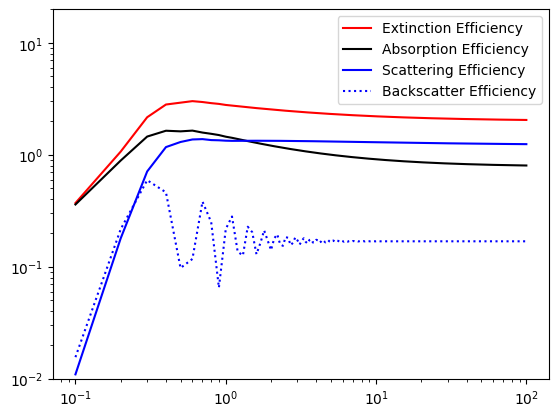

In [5]:
############################# Reproduce figure 8-19 from Ulaby and Long
e_b = 1
e_p = 3.2*(1-1j)
m = np.sqrt(e_p/e_b)
X = np.arange(0.1,100,0.1)
qext, qsca, qback, g = miepython.efficiencies(m,X,1)

plt.loglog(X,qext,c='red',label='Extinction Efficiency')
plt.loglog(X,qext-qsca,c='black',label='Absorption Efficiency')
plt.loglog(X,qsca,c='blue',label='Scattering Efficiency')
plt.loglog(X,qback,c='blue',ls=':',label='Backscatter Efficiency')
plt.legend()
plt.ylim([0.01,20])

(0.01, 20)

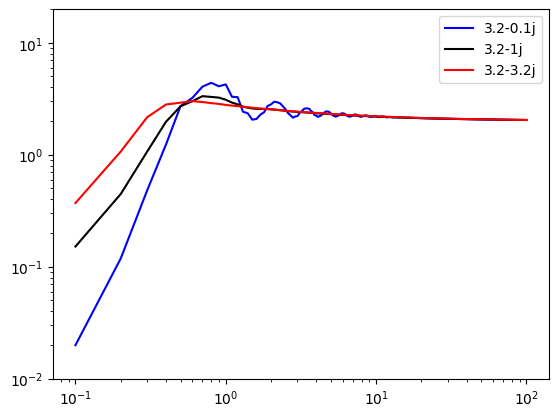

In [6]:
############################# Reproduce figure 8-20 from Ulaby and Long
X = np.arange(0.1,100,0.1)

e_b = 1
e_p_opts = [3.2-0.1j,3.2-1j,3.2-3.2j]
e_p_labels = ['3.2-0.1j','3.2-1j','3.2-3.2j']
e_p_colors = ['blue','black','red']


qext = []
for e_p in e_p_opts:
    m = np.sqrt(e_p/e_b)
    qext_temp, qsca_temp, qback_temp, g_temp = miepython.efficiencies(m,X,1)
    qext.append(qext_temp)

for i in np.arange(len(e_p_opts)):
    plt.loglog(X,qext[i],c=e_p_colors[i],label=e_p_labels[i])
    
plt.legend()
plt.ylim([0.01,20])

In [7]:
def _pos_imag_sqrt(z):
    """
    Square root with the physically common branch choice Im(sqrt(z)) >= 0.
    This avoids sign flips in lossy media when both media use the same convention.
    """
    w = np.sqrt(z + 0j)
    return np.where(np.imag(w) >= 0, w, -w)

def fresnel_reflectivity_normal(eps1, eps2, return_amplitude=False):
    """
    Normal-incidence Fresnel reflectivity between two (possibly complex) permittivities.

    Parameters
    ----------
    eps1 : float|complex|array
        Permittivity of incident medium (relative ε_r if you like).
    eps2 : float|complex|array
        Permittivity of transmission medium.
    return_amplitude : bool
        If True, also return complex amplitude r in addition to power R.

    Returns
    -------
    R : float|array
        Power reflectivity, R = |r|^2.
    r : complex|array  (only if return_amplitude=True)
        Complex amplitude reflection coefficient.
    """
    n1 = _pos_imag_sqrt(eps1)
    n2 = _pos_imag_sqrt(eps2)
    r = (n2 - n1) / (n2 + n1)
    R = np.abs(r) ** 2
    return (R, r) if return_amplitude else R

def refl_to_dB(R):
    """Convert linear reflectivity to dB (power)."""
    R = np.asarray(R, dtype=float)
    return 10.0 * np.log10(R)



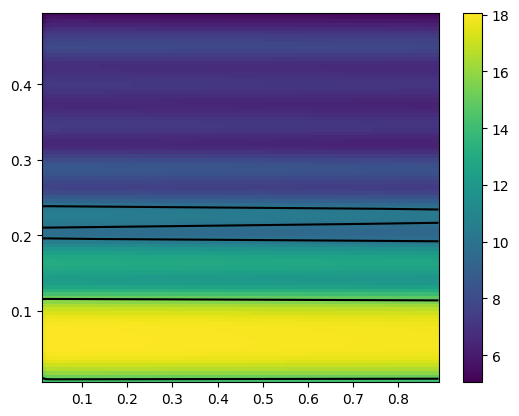

In [13]:
################################################################
### Generate the scattering and attenuation cross sections for a variety of particle sizes
### and volume densities:

particle_radius = np.expand_dims(np.arange(0.005,0.5,0.005),1)


f = 150e6                            # Instrument Frequency
e_b = 3.16                           # Permittivity  of light in background material
e_p = 6                              # Speed of light in debris particle

c_0 = 299792458                      # Speed of light in a vacuum
c_b = c_0/np.sqrt(np.real(e_b))      # Speed of light in background material
c_p = c_0/np.sqrt(np.real(e_p))      # Speed of light in debris particle

lambda0 = c_0/f                      # Wavelength in vacuum
k_0 = f/c_0                          # Wavenumber in vacuum
lambda_b = c_b/f                     # Wavelength in background material
k_b = f/c_b                          # Wavenumber in background material
lambda_p = c_p/f                     # Wavelength in particle
k_p = f/c_p                          # Wavenumber in particle

m = np.sqrt(e_p)/np.sqrt(e_b)+0.1j

X = 2*np.pi*particle_radius/lambda_b # Effective radius (non-dimensional with wavelength)
p = np.expand_dims(np.arange(0.01,0.90,0.01),1).T

####### Assemble the options for number density given particle size and density
N = np.matmul(3/(4*np.pi*particle_radius**3),p)

qext, qsca, qback, g = miepython.efficiencies(m,X,1)
qback = np.expand_dims(qback,1)
qext = np.expand_dims(qext,1)

sigma_back = np.pi*particle_radius**2*qback
sigma_ext = np.pi*particle_radius**2*qext

k_back = N*sigma_back
k_ext = N*sigma_ext

layer_thickness = lambda_b/2
layer_thickness = 30
dx = 0.01
layers = np.arange(dx,layer_thickness,dx)

###### Here is a model that manages extinction losses through the particle layer
final_sigma = np.zeros(k_ext.shape)
for layer in layers:
    final_sigma = final_sigma + dx*k_back*np.exp(-2*k_ext*layer)

###### Here we simply calculate the expected reflectivity given the fresnel zone
depth = 1000
elevation = 500
final_sigma = final_sigma*np.pi*lambda_b/4*(elevation+depth/np.sqrt(e_b))


filter_val = 0.1
filter_length = int(filter_val/np.median(np.diff(particle_radius.T)))
final_sigma = signal.fftconvolve(final_sigma, np.ones([filter_length,1])/filter_length, mode = 'same')


#final_sigma = k_back*layer_thickness

xgrid,ygrid = np.meshgrid(p,particle_radius)

cdata = plt.imshow(10*np.log10(final_sigma),origin='lower',extent=[p[0,0],p[-1,-1],particle_radius[0,0],particle_radius[-1,-1]])
cdata2 = plt.contour(xgrid,ygrid,10*np.log10(final_sigma),levels=np.arange(0,40,5),colors='black')
plt.colorbar(cdata)
plt.gca().set_aspect('auto')

19.399670692397315
40.066311826681826


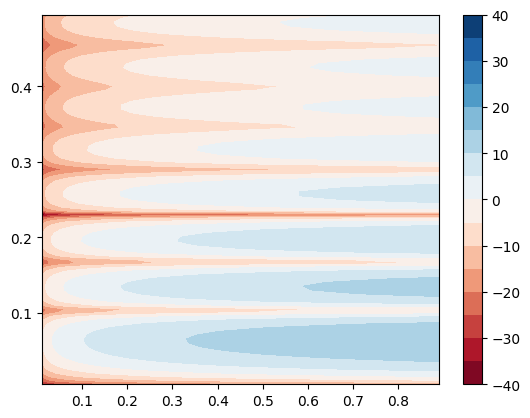

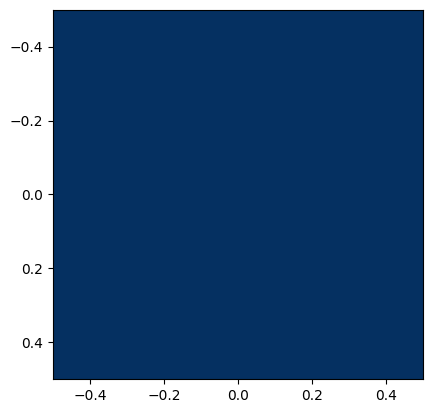

In [15]:
depth=1000
R = fresnel_reflectivity_normal(3.16,3.18)
isochron = refl_to_dB(R*np.pi**3*(elevation+depth/np.sqrt(e_b))**2)
print(isochron)

R = fresnel_reflectivity_normal(3.16,6)
debris_layer = refl_to_dB(R*np.pi**3*(elevation+depth/np.sqrt(e_b))**2)
print(debris_layer-isochron)

cdata = plt.contourf(xgrid,ygrid,10*np.log10(k_back*np.pi*lambda_b*depth/2)-isochron,levels=np.arange(-40,41,5),cmap='RdBu',vmin=-40,vmax=40)
plt.colorbar(cdata)
plt.savefig('Scattering.pdf')

plt.figure()
plt.imshow(np.array([[debris_layer-isochron]]),cmap='RdBu',vmin=-40,vmax=40)
plt.savefig('Scattering2.pdf')

In [264]:

# -----------------------------
# 1) Build single-scatter inputs from Mie
# -----------------------------
def mie_legendre_moments(m, d, lambda0, NLeg_all=128, quad_n=800, n_env=1.0):
    """
    Return (omega0, Legendre moments g_l[0:NLeg_all], qext, qsca, g_asym) for a single sphere.
    Phase function p(mu) is normalized over 4π to match PythonicDISORT conventions.
    """
    # Size parameter and useful μ grid for Gauss–Legendre integration
    x = np.pi * d / lambda0 * 2 * n_env  # 2πa/λ, with a=d/2; include medium index if desired

    # Efficiencies and asymmetry parameter g from miepython (v3 API)
    qext, qsca, qback, g_asym = miepython.efficiencies(m, d, lambda0)  # also works with (m, x) via efficiencies_mx
    omega0 = qsca / qext

    # Gauss–Legendre nodes/weights on μ ∈ [-1, 1]
    mu_nodes, w = L.leggauss(quad_n)

    # Unpolarized phase function p(mu) normalized such that ∫_{4π} p dΩ = 4π (mie norm='4pi')
    # i_unpolarized signature prefers (m, x, mu); '4pi' matches PythonicDISORT's p(ν) convention.
    p_mu = miepython.i_unpolarized(m, x, mu_nodes, norm='4pi')  # [1/sr], integrates to 4π over Ω

    # Legendre moments g_l = 0.5 ∫_{-1}^1 p(mu) P_l(mu) dmu
    # Build Vandermonde of Legendre polynomials evaluated at mu_nodes
    # L.legval takes coeffs where [0,0,...,1] selects P_l
    g_moms = np.empty(NLeg_all)
    for ell in range(NLeg_all):
        P_l = L.legval(mu_nodes, [0]*ell + [1])
        g_moms[ell] = 0.5 * np.sum(w * p_mu * P_l)

    # sanity: g_moms[0] ~ 1.0 (since ∫ p dΩ = 4π ⇒ ∫_{-1}^1 p dμ = 2 ⇒ g0=1)
    return omega0, g_moms, qext, qsca, g_asym

# -----------------------------
# 2) Optical depth from particle concentration
# -----------------------------
def optical_depth_from_microphysics(qext, d, number_density, thickness):
    """
    qext: efficiency (dimensionless)
    d: particle diameter [m]
    number_density: particles per m^3
    thickness: layer thickness [m]
    """
    r = 0.5 * d
    sigma_geom = np.pi * r**2
    sigma_ext = qext * sigma_geom   # [m^2]
    tau = number_density * sigma_ext * thickness
    return tau

# -----------------------------
# 3) Run PythonicDISORT and report backscatter
# -----------------------------
def backscatter_flux_from_layer(
    m=1.33 + 0.0j, d=10e-6, lambda0=532e-9,  # optics
    number_density=1e8, thickness=10.0,      # microphysics & geometry
    mu0=0.8, F0=1.0,                          # illumination: incident irradiance F0 [W/m^2] at zenith cosine mu0
    NQuad=16, NLeg_all=128, use_delta_M=True
):
    # Single-scatter properties & Legendre moments from Mie
    omega0, g_moms, qext, qsca, g_asym = mie_legendre_moments(
        m, d, lambda0, NLeg_all=NLeg_all
    )

    # Layer optical depth
    tau = optical_depth_from_microphysics(qext, d, number_density, thickness)

    # Streams and truncation
    NLeg = NQuad                      # DISORT needs NLeg ≤ NQuad; simplest choice is equality
    Leg_coeffs_all = g_moms           # unweighted moments (PMOM); shape (NLeg_all,)
    if NLeg_all < NLeg:
        raise ValueError("Increase NLeg_all to be at least NQuad.")

    # Optional delta-M scaling (recommended for forward-peaked phase functions)
    f_arr = 0.0
    if use_delta_M:
        f_arr = Leg_coeffs_all[NLeg]  # recommended choice (DISORT-style)
        # PythonicDISORT also accepts per-layer f; here we have one layer only.

    # Beam definition: PythonicDISORT uses I0 (beam intensity), not flux.
    # If you know the incident irradiance F0, set I0 = F0 / mu0 so that beam flux = μ0*I0 = F0
    I0 = F0 / mu0
    phi0 = 0.0

    # Pack layer arrays; single layer can be passed as scalars or 1D arrays
    tau_arr   = float(tau)
    omega_arr = float(omega0)

    print(tau_arr)
    print(omega_arr)
    print(f_arr)
    # Solve (flux-only is much faster when you just need hemispheric power)
    results = PythonicDISORT.pydisort(
        tau_arr, omega_arr,
        NQuad,
        Leg_coeffs_all,
        mu0, I0, phi0,
        NLeg=NLeg,
        only_flux=True,
        f_arr=f_arr,
        NT_cor=True  # good default per docs
    )

    # Unpack upward (+) and downward (-) flux functions
    mu_arr, Fp_func, Fm_func = results[:3]

    # Upward (hemispheric) flux at τ=0 is the total backscattered power per unit area [W/m^2]
    F_up_at_top = float(Fp_func(0.0))   # τ=0 is the top boundary

    # Directional-hemispherical reflectance (a.k.a. “albedo” for this geometry)
    R_dir_hemi = F_up_at_top / F0

    return {
        "tau": tau,
        "omega0": omega0,
        "g_asym": g_asym,
        "reflectance_dir_hemi": R_dir_hemi,
        "F_back_up_top_Wm2": F_up_at_top,
        "qext": qext,
        "qsca": qsca,
        "NQuad": NQuad,
        "NLeg": NLeg,
        "deltaM_f": f_arr,
        "legs": Leg_coeffs_all
    }



def sigma0_from_disort(
    tau, omega0, Leg_coeffs_all,
    mu0=1.0, F0=1.0, phi0=0.0,
    NQuad=32, NLeg=None, NFourier=16,
    deltaM_f=0.0, NT_cor=True
):
    """
    Return (sigma0, sigma0_dB, L_back) for monostatic backscatter.
    If mu0=1 -> nadir. For oblique, use your mu0 in both transmit and receive.
    """
    if NLeg is None:
        NLeg = NQuad
    # DISORT solve with intensity
    mu_arr, Fp, Fm, u0, u = PythonicDISORT.pydisort(
        tau, omega0, NQuad, Leg_coeffs_all, mu0, I0=F0/mu0, phi0=phi0,
        NLeg=NLeg, NFourier=NFourier, only_flux=False,
        f_arr=deltaM_f, NT_cor=NT_cor
    )

    # Backscatter look direction: (mu=mu0, phi=phi0+pi)
    phi_back = (phi0 + np.pi) % (2*np.pi)
    u_up = u(0.0, phi_back)                    # shape: (len(mu_arr),)
    N = NQuad // 2
    mu_pos = mu_arr[:N]                        # upward streams (μ>0)
    L_upward = u_up[:N]                        # diffuse radiance only (no direct up at top)

    # Interpolate to the exact μ = μ0 (DISORT radiation is tabulated at quadrature μ)
    L_back = pdis.interpolate(mu_pos, L_upward, np.array([mu0]))[0]

    # σ0 = 4π μ0 L_back / F0  (nadir: μ0=1)
    sigma0 = 4.0*np.pi * mu0 * (L_back / F0)
    sigma0_dB = 10.0*np.log10(sigma0)         # dB (unitless)

    return float(sigma0), float(sigma0_dB), float(L_back)



In [265]:
N[10,0]

np.float64(14.349055725790716)

In [267]:
out = backscatter_flux_from_layer(
    m=m,     # example refractive index
    d=15e-6,             # 15 µm spheres
    lambda0=500e-9,      # green
    number_density=10e5,  # m^-3
    thickness=20,      # 20 m layer
    mu0=1,             # solar/radar zenith cosine
    F0=1.0,              # 1 W m^-2 incident (use your actual irradiance/power density)
    NQuad=16,
    NLeg_all=128,
    use_delta_M=True
)
for k, v in out.items():
    print(f"{k:26s}: {v}")



# ---------- example (nadir) ----------
# Suppose you've already computed:
#   tau        (scalar)
#   omega0     (scalar)
#   Leg_coeffs_all  (1D array of unweighted Legendre moments, g_ell, ell=0..M)
sigma0, sigma0_dB, Lback = sigma0_from_disort(
    tau=out['tau'], omega0=out['omega0'], Leg_coeffs_all=out['legs'],
    mu0=1.0, F0=1.0, NQuad=32, NFourier=16, deltaM_f=out['legs'][32]
)
print("σ0 (linear):", sigma0)
print("σ0 (dB):    ", sigma0_dB)

0.00739371062500847
0.5317562569799554
0.8844962949243123
tau                       : 0.00739371062500847
omega0                    : 0.5317562569799554
g_asym                    : 0.9638325487430606
reflectance_dir_hemi      : 5.1473870005582496e-05
F_back_up_top_Wm2         : 5.1473870005582496e-05
qext                      : 2.0919921666865156
qsca                      : 1.1124299241886084
NQuad                     : 16
NLeg                      : 16
deltaM_f                  : 0.8844962949243123
legs                      : [1.         0.96447419 0.95052732 0.93957704 0.93183267 0.92593051
 0.92101871 0.91665668 0.91262076 0.90879327 0.90510837 0.90152645
 0.89802203 0.89457769 0.89118102 0.88782287 0.88449629 0.88119596
 0.87791769 0.87465815 0.87141467 0.86818509 0.86496762 0.86176079
 0.85856339 0.85537437 0.85219286 0.84901813 0.84584954 0.84268654
 0.83952867 0.83637551 0.83322672 0.83008197 0.82694101 0.82380359
 0.82066951 0.81753857 0.81441062 0.81128551 0.8081631  0.8050433

TypeError: interpolate() takes 1 positional argument but 3 were given

In [ ]:
## pip install miepython PythonicDISORT numpy scipy

#multiple_scattering = []
for density in N:
    for radius in particle_radius:
    
        out = backscatter_flux_from_layer(
            m=m,     # example refractive index
            d=radius*2,             # 15 µm spheres
            lambda0=lambda_b,      # green
            number_density=density,  # m^-3
            thickness=layer_thickness,      # 20 m layer
            mu0=1,             # solar/radar zenith cosine
            F0=1.0,              # 1 W m^-2 incident (use your actual irradiance/power density)
            NQuad=16,
            NLeg_all=128,
            use_delta_M=True
        )
        for k, v in out.items():
            print(f"{k:26s}: {v}")




In [232]:
R

np.float64(6.239260672569086e-07)